In [1]:
DATA_PATH = "../data/processed/02_cleaned.pkl"

MLFLOW_TRACKING_URI = "../models/mlruns"
MLFLOW_EXPERIMENT_NAME = "churn_rate_prediction"

LOG_PATH = "../models/temp/"
LOG_DATA_PKL = "data.pkl"
LOG_MODEL_PKL = "model.pkl"
LOG_METRICS_PKL = "metrics.pkl"

In [2]:
# Load packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import os
import pickle

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix

import mlflow
from mlflow.tracking import MlflowClient

___
## Functions

In [3]:
def calculate_quality(ground_truth, predictions, metric_function, model_name):
    """
    Calculate the quality of the model according to different metric scores
    Input:
        ground_truth: from real observed data
        predictions: the predicted values from the model
        metric_function: the metric score funcrion used to measure performance
    Output:
        A dict of all scores for the given inputs
    """
    quality_score = {}
    quality_score[model_name] = round(metric_function(ground_truth, predictions), 3)
    quality_score = pd.Series(quality_score.values(), index=quality_score.keys())
    
    return quality_score

In [46]:
def get_threshold(X_train, y_train, model):
    """
    Get the best threshold for the classification 
    Input: 
        X_train: train dataset
        y_train: train target data
        model: model used
    Output:
        the value of the best threshold
    """
    predict_prob = model.predict_proba(X_train.values)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_train.values, predict_prob)
    #gmean = np.sqrt(tpr * (1-fpr))
    #optimal_idx = np.argmax(gmean)
    optimal_idx = np.argmax(tpr - fpr)
    
    return round(thresholds[optimal_idx], 3)

In [64]:
def get_threshold_precision_recall(X, y, model):
    """
    A precision-recall curve focuses on the performance of a classifier on the positive (minority class) only.
    Get the best threshold for the classification 
    Input: 
        X_train: train dataset
        y_train: train target data
        model: model used
    Output:
        the value of the best threshold
    """
    predict_prob = model.predict_proba(X.values)[:,1]
    
    precision, recall, thresholds = precision_recall_curve(y.values, predict_prob)
    #gmean = np.sqrt(tpr * (1-fpr))
    f_scores = (2 * precision * recall) / (precision + recall)
    optimal_idx = np.argmax(f_scores)
    
    return round(thresholds[optimal_idx], 3)

In [5]:
def evaluate_model(model, data_list, metrics_list, model_name, threshold=0.5):
    """
    Get the scores of the model to better understand its performance
    Input:
        data_list: a list of all data that we evaluate model upon, train and test data.
                typical input : [[X_train, y_train, 'train'], [X_test, y_test, 'test']]
        scores_list: a list of all metrics used in the evaluation. 
                typical input : [accuracy_score, precision_score, recall_score, f1_score]
        model_name: a string input used as the index for score dataframe.
    Output:
        scores: a dataframe of evaluation based on data.
        general_error: the generalized error that would be used for logging in mlflow
    """
    predicts = []
    scores = []
    for [X,y,stage] in data_list:

        probas = model.predict_proba(X.values)[:,1]
        predictions = pd.DataFrame(probas >= threshold ,
                                  columns=y_test.columns)
        predicts.append(predictions)

        result = {score.__name__:calculate_quality(y, predictions, score, f"{model_name}_{stage}")
                        for score in metrics_list}

        result = pd.concat(result, axis=1)
        scores.append(result)
    scores = pd.concat(scores)
    return scores, predicts

___
## Intialize

In [6]:
Path(MLFLOW_TRACKING_URI).mkdir(parents=True, exist_ok=True)
Path(LOG_PATH).mkdir(parents=True, exist_ok=True)

___
## Read data

In [7]:
df = pd.read_pickle(DATA_PATH)
df.sample(5)

,seniorcitizen,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
546,0,1.0,39,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,86.30,3266.00,1.0
1386,0,0.0,64,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,3.0,86.55,5632.55,0.0
5468,0,0.0,7,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,79.70,586.05,1.0
5951,0,0.0,37,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,0.0,3.0,100.30,3541.40,0.0
2377,0,1.0,47,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,55.30,2654.05,0.0


___
## Split data for modeling

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('churn', axis=1),
                                                    df[['churn']],
                                                    test_size=0.2,
                                                    random_state=42)

In [9]:
# quick check of splitted data:
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
X_train.sample(5)

X_train shape (5600, 17)
X_test shape (1400, 17)


,seniorcitizen,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
5519,0,0.0,1,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,55.70,55.70
3249,0,1.0,10,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,55.55,551.30
3588,0,0.0,9,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,0.0,1.0,3.0,69.05,653.95
1320,0,1.0,32,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,0.0,1.0,94.80,3131.55
1032,1,0.0,8,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,0.0,1.0,0.0,92.10,729.95


___
## Intializing MLFLOW

In [10]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = MlflowClient()

In [11]:
try:
    mlflow.create_experiment(MLFLOW_EXPERIMENT_NAME)
except:
    print(f'Experiment "{MLFLOW_EXPERIMENT_NAME}" exists at "{mlflow.get_tracking_uri()}"')

In [12]:
exp = client.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)
print(exp)

<Experiment: artifact_location='../models/mlruns/0', experiment_id='0', lifecycle_stage='active', name='churn_rate_prediction', tags={}>


___
## Base model; Logistic Regression
**1. without balancing**

In [13]:
clf = make_pipeline(MinMaxScaler(),
                    LogisticRegression())

clf.fit(X_train.values, (y_train.values).reshape(-1,))

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])

### Evaluating model

In [36]:
# Prepare data and metrics that would be used to evaluate the model
data_list = [[X_train, y_train, 'train'], [X_test, y_test, 'test']]
metrics_list = [accuracy_score, precision_score, recall_score, f1_score]

In [37]:
# Use evaluate_model function to run evaluations
scores, predicts = evaluate_model(clf, data_list, metrics_list, "LogisticRegression")
scores

,accuracy_score,precision_score,recall_score,f1_score
LogisticRegression_train,0.807,0.657,0.547,0.597
LogisticRegression_test,0.797,0.671,0.495,0.570


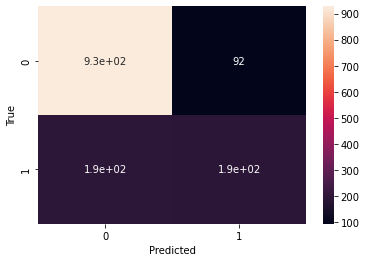

In [38]:
cm = confusion_matrix(y_test, predicts[1])
s = sns.heatmap(cm, annot=True) 
s.set(xlabel="Predicted", ylabel="True")
plt.show()

<AxesSubplot:>

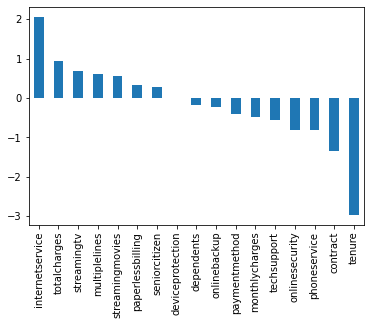

In [39]:
# To get the weights of all the variables
weights = pd.Series(clf.named_steps['logisticregression'].coef_[0],
                 index=X_train.columns.values)
weights.sort_values(ascending = False).plot(kind='bar')

**We can see there are equal weights on services columns; it would be better if we used dimensionality reduction on it**

In [56]:
# Get the threshold using precision_recall_curve
thrs = get_threshold_precision_recall(X_test, y_test, clf)
thrs

0.274

In [55]:
# Use evaluate_model function to run evaluations
scores, predicts = evaluate_model(clf, data_list, metrics_list, "LogisticRegression", 0.274)
scores

,accuracy_score,precision_score,recall_score,f1_score
LogisticRegression_train,0.772,0.759,0.796,0.777
LogisticRegression_test,0.767,0.551,0.774,0.643


In [57]:
# Get the threshold using roc_curve
thrs = get_threshold(X_test, y_test, clf)
thrs

0.251

In [50]:
# Use evaluate_model function to run evaluations
scores, predicts = evaluate_model(clf, data_list, metrics_list, "LogisticRegression", 0.251)
scores

,accuracy_score,precision_score,recall_score,f1_score
LogisticRegression_train,0.772,0.749,0.82,0.783
LogisticRegression_test,0.755,0.532,0.80,0.639


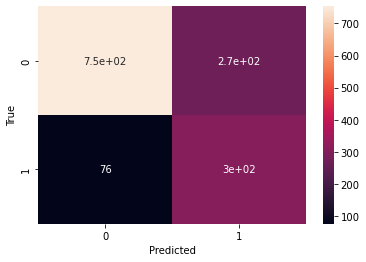

In [51]:
cm = confusion_matrix(y_test, predicts[1])
s = sns.heatmap(cm, annot=True) 
s.set(xlabel="Predicted", ylabel="True")
plt.show()

___
## Now Trying to use resampling:

In [21]:
sm = SMOTE(random_state=42)
X_train_balance, y_train_balance = sm.fit_resample(X_train, y_train)

In [22]:
y_train_balance.value_counts()

churn
0.0      4134
1.0      4134
dtype: int64

**1. with balancing**

In [23]:
clf_balance = make_pipeline(MinMaxScaler(),
                    LogisticRegression())

clf_balance.fit(X_train_balance.values, (y_train_balance.values).reshape(-1,))

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])

### Evaluate the model:

In [43]:
# Prepare data and metrics that would be used to evaluate the model
data_list = [[X_train_balance, y_train_balance, 'train'], [X_test, y_test, 'test']]
metrics_list = [accuracy_score, precision_score, recall_score, f1_score]

In [44]:
# Use evaluate_model function to run evaluations
scores, predicts = evaluate_model(clf_balance, data_list, metrics_list, "LogisticRegression")
scores

,accuracy_score,precision_score,recall_score,f1_score
LogisticRegression_train,0.777,0.756,0.818,0.786
LogisticRegression_test,0.755,0.534,0.766,0.629


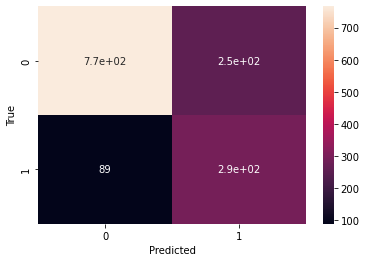

In [26]:
cm = confusion_matrix(y_test, predicts[1])
s = sns.heatmap(cm, annot=True) 
s.set(xlabel="Predicted", ylabel="True")
plt.show()

<AxesSubplot:>

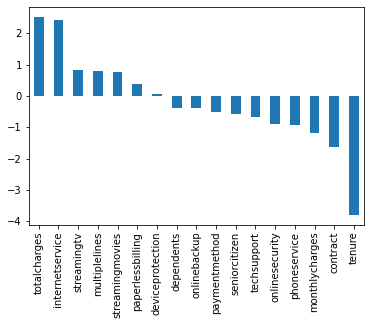

In [27]:
# To get the weights of all the variables
weights = pd.Series(clf_balance.named_steps['logisticregression'].coef_[0],
                 index=X_train_balance.columns.values)
weights.sort_values(ascending = False).plot(kind='bar')

In [59]:
# Get the threshold using precision_recall_curve
thrs = get_threshold_precision_recall(X_test, y_test, clf_balance)
thrs

0.546

In [60]:
# Use evaluate_model function to run evaluations
scores, predicts = evaluate_model(clf_balance, data_list, metrics_list, "LogisticRegression", 0.546)
scores

,accuracy_score,precision_score,recall_score,f1_score
LogisticRegression_train,0.776,0.773,0.780,0.776
LogisticRegression_test,0.774,0.566,0.718,0.633


In [61]:
thrs = get_threshold(X_test, y_test, clf_balance)
thrs

0.478

In [62]:
# Use evaluate_model function to run evaluations
scores, predicts = evaluate_model(clf_balance, data_list, metrics_list, "LogisticRegression", 0.478)
scores

,accuracy_score,precision_score,recall_score,f1_score
LogisticRegression_train,0.776,0.748,0.834,0.789
LogisticRegression_test,0.751,0.528,0.779,0.629


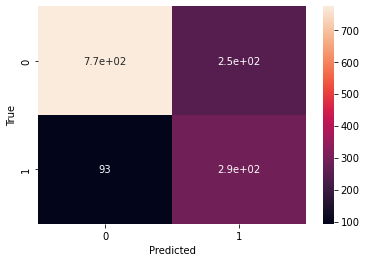

In [30]:
cm = confusion_matrix(y_test, predicts[1])
s = sns.heatmap(cm, annot=True) 
s.set(xlabel="Predicted", ylabel="True")
plt.show()

## Balance doesn't help:
**As we can see balancing the data doesn't help at all. Even it makes the model performs worse**

### Log run

In [31]:
# Data details
data_details = {"data_path": DATA_PATH,
                "training_indices": X_train.index.tolist(),
                "test_indices": X_test.index.tolist(),
                "feature_names": X_train.columns.tolist(),
                "target_names": y_train.columns.tolist()}

with open(os.path.join(LOG_PATH, LOG_DATA_PKL), "wb") as output_file:
    pickle.dump(data_details, output_file)

In [32]:
# Model details
model = {"model_description": "Base Model, Logistic Regression",
         "model_details": str(clf),
         "model_object": clf}

with open(os.path.join(LOG_PATH, LOG_MODEL_PKL), "wb") as output_file:
    pickle.dump(model, output_file)

In [33]:
# Performance details
regression_metrics = {"train_scores": scores.iloc[0],
                      "test_scores": scores.iloc[1]}

with open(os.path.join(LOG_PATH, LOG_METRICS_PKL), "wb") as output_file:
    pickle.dump(regression_metrics, output_file)

### Logging

In [34]:
# Start a new run and track
with mlflow.start_run(experiment_id=exp.experiment_id, run_name=model["model_description"]):
    # log pickle
    mlflow.log_artifacts(LOG_PATH)
    
    # Track metrics
    for metric, score in scores.iloc[1].items():
        mlflow.log_metric(metric, score)